In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import shutil

In [2]:
import h5py

train_file = 'MA0035_4_m5_train.h5'
test_file = 'MA0035_4_m5_test.h5'

h5_train = h5py.File(train_file, 'r')
h5_test = h5py.File(test_file, 'r')

train_data = h5_train['data'][:90000]
train_binlabels = h5_train['binlabels'][:90000]

val_data = h5_train['data'][-10000:]
val_binlabels = h5_train['binlabels'][-10000:]

test_data = h5_test['data'][:]
test_binlabels = h5_test['binlabels'][:]

In [3]:
def train_model(hyperparameters, log_dir):
    board_log = log_dir + '/board'
    hparams_log = log_dir + '/hparams.txt'

    my_callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir=board_log),
    ]

    with open(hparams_log, 'w') as hparam_file:
        json.dump(hyperparameters, hparam_file)

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(4, 1000)),
            tf.keras.layers.Dropout(hyperparameters['l0_dropout_rate']),
            tf.keras.layers.Dense(hyperparameters['l1_hidden_units'], activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(hyperparameters['l1_dropout_rate']),
            tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        ]
    )
    with tf.device('/GPU:0'):
        model.compile(
            optimizer = tf.optimizers.Adam(),
            loss = 'binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc')]
        )

        history = model.fit(train_data, train_binlabels,
                epochs=500, 
                validation_data=(val_data, val_binlabels),
                batch_size=hyperparameters['batch_size'],
                callbacks=my_callbacks)

    return model, history

In [4]:
def plot_and_save_roc(false_positive_rate, true_positive_rate, log_dir):
    roc = plt.figure(0)

    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.savefig(log_dir + '/roc.pdf')
    pickle.dump(roc, open((log_dir + '/pickle/roc.fig.pickle'), 'wb'))

In [5]:
def plot_and_save_loss(history, log_dir):
    loss = plt.figure(1)
    history_loss = history.history['loss']
    history_val_loss = history.history['val_loss']
    epochs = range(len(history_loss))

    plt.plot(epochs, history_loss, 'ko', label='Training loss')
    plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig(log_dir + '/loss.pdf')
    pickle.dump(loss, open((log_dir + '/pickle/loss.fig.pickle'), 'wb'))

In [6]:
def plot_and_save_auc(history, log_dir):
    auc = plt.figure(2)

    history_auc = history.history['auc']
    history_val_auc = history.history['val_auc']
    epochs = range(len(history_auc))

    plt.plot(epochs, history_auc, 'ko', label='Training auc')
    plt.plot(epochs, history_val_auc, 'b', label='Validation auc')
    plt.title('Training and validation auc')
    plt.ylim(0.46, 1.0)
    plt.legend()

    plt.savefig(log_dir + '/auc.pdf')
    pickle.dump(auc, open((log_dir + '/pickle/auc.fig.pickle'), 'wb'))

In [21]:
import os
L0_DROPOUT_RATES = [0.0, 0.1, 0.3, 0.5, 0.8]
L1_DROPOUT_RATES = [0.5, 0.6, 0.7]
L1_HIDDEN_UNITS = [8, 16, 32, 64, 128, 254, 512]
BATCH_SIZE = [32, 64, 128, 254, 512]
iteration = 0

for l1_hidden_units in L1_HIDDEN_UNITS:
    for l0_dropout_rate in L0_DROPOUT_RATES:
        for l1_dropout_rate in L1_DROPOUT_RATES:
            log_dir = './logs/1_layer_dropout/log' + str(iteration)
            iteration = iteration + 1

            try:
                shutil.rmtree(log_dir)
                os.makedirs(log_dir)
                os.makedirs(log_dir + '/pickle')
            except OSError as e:
                pass

            hparams = {
                'l0_dropout_rate': l0_dropout_rate,
                'l1_dropout_rate': l1_dropout_rate,
                'l1_hidden_units': l1_hidden_units,
                'batch_size': BATCH_SIZE[2],
            }

            model, history = train_model(hparams, log_dir)

7 - val_auc: 0.4997
Epoch 353/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6110 - auc: 0.5253 - val_loss: 0.6198 - val_auc: 0.4995
Epoch 354/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6104 - auc: 0.5293 - val_loss: 0.6207 - val_auc: 0.5000
Epoch 355/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6142 - auc: 0.5219 - val_loss: 0.6202 - val_auc: 0.4980
Epoch 356/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6116 - auc: 0.5280 - val_loss: 0.6209 - val_auc: 0.4999
Epoch 357/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6118 - auc: 0.5290 - val_loss: 0.6205 - val_auc: 0.4996
Epoch 358/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6116 - auc: 0.5285 - val_loss: 0.6205 - val_auc: 0.4985
Epoch 359/500
704/704 [==============================] - 2s 3ms/step - loss: 0.6110 - auc: 0.5308 - val_loss: 0.6219 - val_auc: 0.4977
Epoch 360/500
704/704 [============

313/313 [==============================] - 1s 2ms/step - loss: 0.5768 - auc: 0.5047


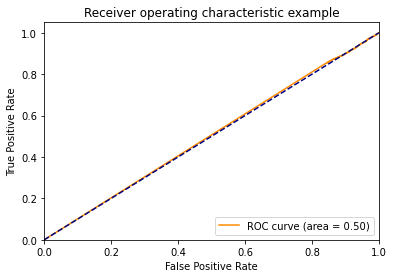

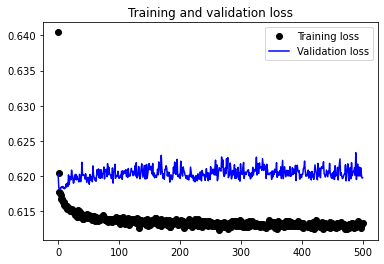

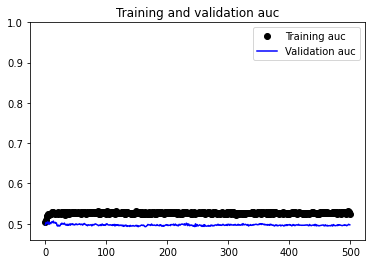

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

acc, auc = model.evaluate(test_data, test_binlabels)
yhat = model.predict(test_data)
fpr, tpr, _ = roc_curve(test_binlabels, yhat)
roc_auc = roc_auc_score(test_binlabels, yhat)

plot_and_save_roc(fpr, tpr, log_dir)
plot_and_save_loss(history, log_dir)
plot_and_save_auc(history, log_dir)

plt.show()
